In [1]:
from __future__ import absolute_import, division, print_function

import os
import json
import pyro
import torch
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import pyro.optim as optim
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
import pyro.distributions as dist
import matplotlib.animation as animation

from torch.distributions import constraints

from functools import partial
from pyro.infer.mcmc import NUTS
from IPython.display import Video
from pyro.infer.mcmc.api import MCMC
from mpl_toolkits.mplot3d import Axes3D
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO

pyro.set_rng_seed(0)

# Bayesian Kriging to Predict Ground Water Levels

In [2]:
%matplotlib inline
logging.basicConfig(format="%(message)s", level=logging.INFO)

# Enable validation checks
pyro.enable_validation(True)
smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("0.4.1")

In [3]:
pyro.set_rng_seed(1)

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Helper Functions

In [5]:
def pairwise_distances(x, y=None):
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    dist = torch.clamp(dist, 0.0, np.inf)
    
    return dist

In [6]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [7]:
def visualize_posterior(samples):
    import math
    
    sites = list(samples.keys())
    
    r = int(math.ceil(math.sqrt(len(samples))))
    fig, axs = plt.subplots(nrows=r, ncols=r, figsize=(15, 13))
    fig.suptitle("Marginal Posterior Density", fontsize=16)
    
    
    for i, ax in enumerate(axs.reshape(-1)):
        if i >= len(sites):
            break
        site = sites[i]
        sns.distplot(samples[site], ax=ax)
        ax.set_title(site)
        
    handles, labels = ax.get_legend_handles_labels()

### Loading Data

In [8]:
data = pd.read_csv("data/sample_data2.csv", encoding="ISO-8859-1")

data_wells = data[data.type == "well"]
data_farms = data[data.type == "farm"]

XW, YW = [], []
for t in data_wells["timestep"].unique():
    data_ = data_wells[data_wells["timestep"] == t]

    XW.append(data_[["latitude", "longitude"]].values)
    YW.append(data_["observation"].values)
    
XW = XW[0]

XF = data_farms[["latitude", "longitude"]].values
YF = data_farms["observation"].values

In [9]:
plt.clf()
fig = plt.figure(figsize=(10, 10), dpi=100)

plt.ion()

plt.scatter(XF[:, 0], XF[:, 1], marker="s", s=7, color="lightgreen")

scat = plt.scatter(XW[:, 0], XW[:, 1], marker="s", s=20, c=[(0, 0, 0, 1)] * len(XW))
label = plt.text(0, 0, '', fontsize=12)

colors = []
for obs in YW:
#     min_v = min(obs)
#     max_v = max(obs)
#     colors.append([max((x - min_v) / (max_v - min_v), 0.1) for x in obs])
    colors.append([min(1 - abs(x) / 15, 1) for x in obs])
    
colors = np.array(colors)

def update_plot(i, scat):
    scat.set_array(colors[i])
    label.set_text(["Sp", "Su", "Fa", "Wi"][i % 4])
    return scat,

anim = animation.FuncAnimation(fig, update_plot, frames=range(len(XW)), fargs=(scat,), interval=1000)

plt.gray()
plt.close()

<Figure size 432x288 with 0 Axes>

In [10]:
anim.save("includes/data-animation.mp4", fps=1)

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-r', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'includes/data-animation.mp4']


In [11]:
Video("includes/data-animation.mp4")

In [12]:
XW = torch.tensor(XW)
YW = torch.tensor(YW)

XF = torch.tensor(XF)
YF = torch.tensor(YF)

# Bayesian Kernel Regression

## Defining the Model

In [ ]:
def model_kr(XW, YW, use_cuda=False):
    mu_delta = torch.Tensor([1.0]).type_as(XW)
    mu_theta = torch.Tensor([0.0]).type_as(XW)

    delta = pyro.sample("delta", dist.LogNormal(mu_delta, 0.5))
    theta = pyro.sample("theta", dist.LogNormal(mu_theta, 0.5))

    sigma_mu = torch.Tensor([2.0]).type_as(XW)
    mu = pyro.sample("mu", dist.Normal(0, sigma_mu))

    a_sigma = torch.FloatTensor([1.0]).type_as(XW)
    b_sigma = torch.FloatTensor([1.0]).type_as(XW)
    sigma = pyro.sample("sigma", dist.Gamma(a_sigma, b_sigma))
    mean = (
        mu
        - (YF * torch.exp(-pairwise_distances(XW, XF) / theta)).sum(1) * delta
    )

    with pyro.plate("data", len(YW)):
        y = pyro.sample("obs", dist.Normal(mean, sigma), obs=YW)

    return y

In [ ]:
def guide_kr(XW, YW):
    mu_delta = pyro.param("mu_delta", torch.ones(1).type_as(XW), constraint=constraints.positive)
    mu_theta = pyro.param("mu_theta", torch.zeros(1).type_as(XW), constraint=constraints.positive)
    
    sg_delta = pyro.param("sg_delta", torch.ones(1).type_as(XW), constraint=constraints.positive)
    sg_theta = pyro.param("sg_theta", torch.ones(1).type_as(XW), constraint=constraints.positive)
    
    delta = pyro.sample("delta", dist.Normal(mu_delta, sg_delta))
    theta = pyro.sample("theta", dist.Normal(mu_theta, sg_theta))
    
#     mu_sigma = pyro.param("mu_sigma", torch.tensor(1.0).type_as(XW), constraint=constraints.positive)
#     sigma = pyro.sample("sigma", dist.Gamma(mu_sigma, torch.tensor(1.0).type_as(XW)))
    
    mu_mu = pyro.param("mu_mu", torch.randn(1).type_as(XW))
    sg_mu = pyro.param("sg_mu", torch.ones(1).type_as(XW), constraint=constraints.positive)
    mu = pyro.sample("mu", dist.Normal(mu_mu, sg_mu))
    
    mean = mu - delta * (YF * torch.exp(-pairwise_distances(XW, XF) / theta)).sum(1)

In [ ]:
def predict_kr(XW, posterior_samples):
    ps = posterior_samples
    samples = zip(ps["delta"], ps["theta"], ps["mu"], ps["sigma"])
    
    for delta, theta, mu, sigma in samples:
        mean = mu - (YF * torch.exp(-pairwise_distances(XW, XF) / theta)).sum(1) * delta
        yield dist.Normal(mean, sigma).sample()

## Inference

#### HMC

In [ ]:
nuts_kernel = NUTS(partial(model_kr, use_cuda=use_cuda))

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=2000)
mcmc_run = mcmc.run(XW, YW)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [ ]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

In [ ]:
visualize_posterior(hmc_samples)

In [ ]:
svi = SVI(
    partial(model_kr, use_cuda=use_cuda), guide_kr, optim.Adam({"lr": 0.005}), loss=JitTrace_ELBO(), num_samples=1000
)

pyro.clear_param_store()
num_iters = 10000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(XW, YW)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

## Prediction

In [ ]:
results = torch.stack(list(predict_kr(XW, hmc_samples)))

In [ ]:
ax = plt.figure(figsize=(15, 15)).add_subplot(111, projection='3d')

ax.scatter(XW[:, 0], XW[:, 1], YW, marker="x")
ax.scatter(XF[:, 0], XF[:, 1], YF, marker="^")

# for result in results[:100]:
#     ax.scatter(XW[:, 0], XW[:, 1], result, marker=".", color="red")
    
results_mean = results.mean(dim=0).numpy()
results_std = results.std(dim=0).numpy()

ax.scatter(XW[:, 0], XW[:, 1], results_mean, marker="o", color="red", s=15)

ax.scatter(XW[:, 0], XW[:, 1], results_mean - results_std, marker="_", color="green", s=15)
# for i, point in enumerate(XW.numpy().tolist()):
#     ax.plot(point + [results_mean[i] + results_std[i]], point + [results_mean[i] - results_std[i]])
ax.scatter(XW[:, 0], XW[:, 1], results_mean + results_std, marker="_", color="green", s=15)
    
plt.savefig("predictions.png", dpi=240)
plt.show()

In [ ]:
results.mean(0)

In [ ]:
YW

# Gaussian Processes

## Defining the Model

In [13]:
def model_gp(XW, YW):
    assert not torch._C._get_tracing_state()

    delta = pyro.sample("delta", dist.LogNormal(1.0, 0.5))

    theta_f = pyro.sample("theta_f", dist.LogNormal(0.0, 0.5))
    theta_w = pyro.sample("theta_w", dist.LogNormal(0.0, 0.5))

    sigma = torch.exp(-pairwise_distances(XW, XW) / theta_w)

    farm_factor = delta * (YF * torch.exp(-pairwise_distances(XW, XF) / theta_f)).sum(1)

    sf = pyro.sample("sf", dist.Normal(torch.zeros(4), 1))

    data_plate = pyro.plate("data", len(YW[0]))

    mu = 0
    for i in pyro.plate("sequence", len(YW)):
        mu = pyro.sample(
            "mu_{}".format(i), dist.Normal(mu + sf[i % 4], 1.0)
        )
        
        mean = mu - farm_factor
        
        with data_plate:
            pyro.sample(
                "obs_{}".format(i), dist.MultivariateNormal(mean, sigma), obs=YW[i]
            )

In [14]:
def predict_gp(XW, samples):
    pdx = pairwise_distances(XW).cpu().numpy()
    pdf = pairwise_distances(XW, XF).cpu().numpy()
    
    YF_ = YF.cpu().numpy()
    
    delta = samples["delta"]
    theta_w = samples["theta_w"]
    theta_f = samples["theta_f"]
    
    mu = list(zip(*[samples["mu_{}".format(i)] for i in range(len(YW))]))
    mu = np.array(mu)
    
    for i in range(len(delta)):
        sigma = np.exp(-pdx / theta_w[i])
        
        samples = []
        for t in range(len(YW)):
            mean = mu[i, t] - delta[i] * (YF_ * np.exp(-pdf / theta_f[i])).sum(1)
            samples.append(np.random.multivariate_normal(mean, sigma))
            
        samples = np.array(samples)
            
        yield samples

## Inference

In [15]:
nuts_kernel = NUTS(model_gp)

mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=400)
mcmc_run = mcmc.run(XW, YW)

samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 500/500 [1:31:20<00:00, 10.96s/it, step size=1.64e-01, acc. prob=0.953]  


In [ ]:
with open("data/gp-samples-t.json", "r") as f:
    samples = {k: np.array(v) for k, v in json.load(f).items()}

In [16]:
samples_ = {k: v.tolist() for k, v in samples.items()}
with open("data/gp-samples-t.json", "w") as f:
    json.dump(samples_, f)

In [17]:
for site, values in summary(samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: delta
       mean       std        5%       25%       50%       75%       95%
0  0.692805  0.001586  0.690411  0.691728  0.692649  0.693983  0.695122 

Site: theta_f
       mean       std        5%      25%       50%       75%      95%
0  0.598171  0.001764  0.595412  0.59676  0.598262  0.599398  0.60101 

Site: theta_w
       mean       std        5%       25%       50%       75%       95%
0  0.152789  0.067286  0.063652  0.094755  0.154158  0.195553  0.265829 

Site: sf
       mean       std        5%       25%       50%       75%       95%
0 -1.321063  0.283218 -1.780389 -1.534763 -1.313897 -1.124225 -0.872526
1 -1.766521  0.265141 -2.183513 -1.927145 -1.740401 -1.617529 -1.294940
2  2.612201  0.352519  1.986230  2.407188  2.591702  2.830025  3.219515
3  0.030239  0.331872 -0.546031 -0.144143  0.016157  0.237252  0.572623 

Site: mu_0
       mean       std        5%       25%       50%       75%       95%
0 -5.287083  0.063655 -5.391328 -5.327527 -5.288778 -5.246262 -5.182242 

In [19]:
results = np.array(list(predict_gp(XW, samples)))

In [20]:
XW_ = XW.cpu().numpy()
YW_ = YW.cpu().numpy()

XF_ = XF.cpu().numpy()
YF_ = YF.cpu().numpy()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

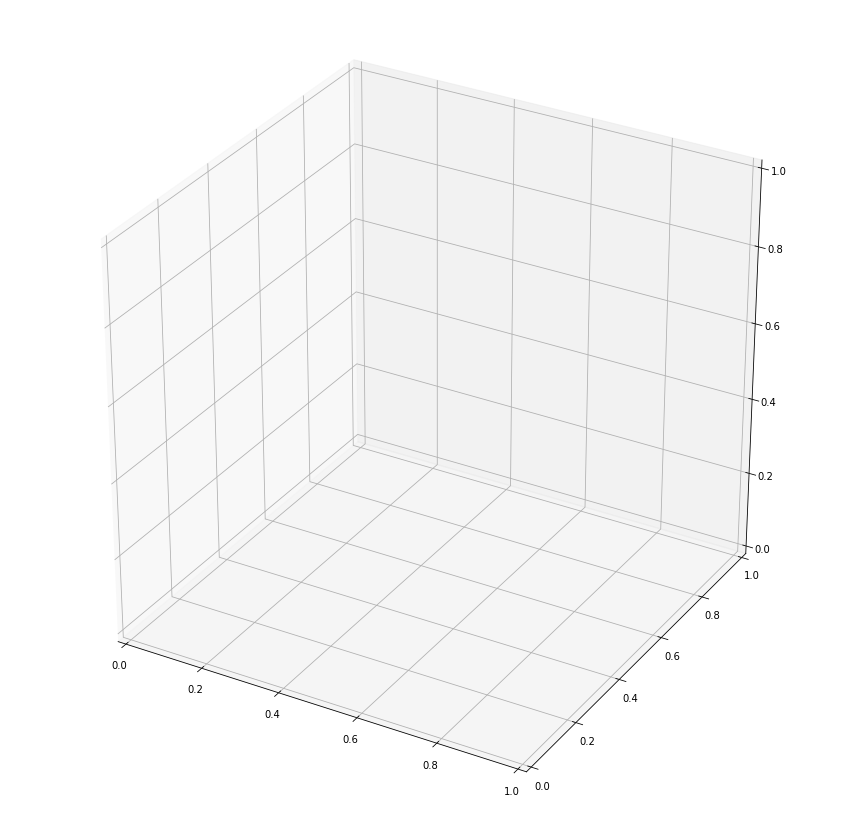

In [21]:
ax = plt.figure(figsize=(15, 15)).add_subplot(111, projection='3d')

ax.scatter(XW_[:, 0], XW_[:, 1], YW_, marker="x")
ax.scatter(XF_[:, 0], XF_[:, 1], np.zeros(YF.shape), marker="^")

# for result in results[:100]:
#     ax.scatter(XW[:, 0], XW[:, 1], result, marker=".", color="red")

results_mean = results.mean(axis=0)
results_std = results.std(axis=0)

ax.scatter(XW_[:, 0], XW_[:, 1], results_mean, marker="o", color="red", s=15)

ax.scatter(XW_[:, 0], XW_[:, 1], results_mean - results_std, marker="_", color="green", s=15)
# for i, point in enumerate(XW.numpy().tolist()):
#     ax.plot(point + [results_mean[i] + results_std[i]], point + [results_mean[i] - results_std[i]])
ax.scatter(XW_[:, 0], XW_[:, 1], results_mean + results_std, marker="_", color="green", s=15)
    
plt.savefig("predictions.png", dpi=240)
plt.show()

In [ ]:
plt.clf()
fig = plt.figure(figsize=(15, 15))
plt.scatter(XF_[:, 0], XF_[:, 1], marker="s", s=10, color="lightgreen")
# plt.scatter(XW_[:, 0], XW_[:, 1], marker="s", s=15, c=[(0, 0, 1, abs(x)/abs(min(YW_))) for x in YW_])

min_v = abs(min(results_mean))
colors = [(0, 0, 1, abs(x)/min_v) for x in results_mean]

plt.scatter(XW_[:, 0], XW_[:, 1], marker="s", s=15, c=colors)
plt.show()